In [1]:
from keras.models import Sequential
from keras.layers import Dense, Activation,Dropout

import ROOT as rt
import uproot
#from root_numpy import root2array, tree2array
#from root_pandas import read_root
import h5py 

from keras.optimizers import Adam
from sklearn.metrics import accuracy_score, roc_curve, auc
from sklearn.model_selection import StratifiedKFold
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

from skopt import gp_minimize
from skopt.space import Real, Integer, Categorical
from skopt.utils import use_named_args

import numpy as np
import numpy.lib.recfunctions as nlr
import pandas as pd
import os, sys
from matplotlib import pyplot as plt
import math
try:
    import setGPU
except:
    os.environ['KERAS_BACKEND'] = 'tensorflow'
    os.environ['CUDA_VISIBLE_DEVICES'] = '5'

Welcome to JupyROOT 6.22/02
setGPU: Setting GPU to: 0


In [2]:
def samp_to_df(samp_name, total_num):
    dfs = []
    for i in range(total_num+1):
        file_name = f'/storage/af/user/schen7/CMSSW_9_4_2/src/Higgs/HHbbgg/HHbbggAna/condor/output/{samp_name}{i}.root'
        samp_file = uproot.open(file_name)
        samp_array = samp_file['tree'].arrays()
        samp_df = pd.DataFrame(samp_array)
        dfs.append(samp_df)
    combine_df = pd.concat(dfs, ignore_index=True)
    return combine_df

In [6]:
# Set up dataframes - 2018 

# Signals
GluGluToHH_df_2018 = samp_to_df('job_2_ntuple20180819v1/GluGluToHHTo2B2G_node_cHHH1_TuneCP5_PSWeights_13TeV-powheg-pythia8Job2ifile', 0)
VBFHH_df_2018= samp_to_df('job_3_ntuple20180819v1/VBFHHTo2B2G_CV_1_C2V_1_C3_1_TuneCP5_PSWeights_13TeV-madgraph-pythia8Job3ifile', 0)

# Backgrounds
VHToGG_df_2018 = samp_to_df('job_4_ntuple20180819v1/VHToGG_M125_13TeV_amcatnloFXFX_madspin_pythia8Job4ifile', 0)
ttHToGG_df_2018 = samp_to_df('job_5_ntuple20180819v1/ttHToGG_M125_TuneCP5_PSweights_13TeV-powheg-pythia8Job5ifile', 0)
VBFHToGG_df_2018 = samp_to_df('job_6_ntuple20180819v1/VBFHToGG_M125_13TeV_amcatnlo_pythia8Job6ifile', 0)
GluGluHToGG_df_2018 = samp_to_df('job_7_ntuple20180819v1/GluGluHToGG_M125_TuneCP5_13TeV-amcatnloFXFX-pythia8Job7ifile', 0)

# Set up dataframes - 2017

# Signals
GluGluToHH_df_2017 = samp_to_df('job_2_ntuple20170819v1/GluGluToHHTo2B2G_node_cHHH1_TuneCP5_PSWeights_13TeV-powheg-pythia8Job2ifile', 3)
VBFHH_df_2017 = samp_to_df('job_3_ntuple20170819v1/VBFHHTo2B2G_CV_1_C2V_1_C3_1_13TeV-madgraphJob3ifile', 1)

# Backgrounds
VHToGG_df_2017 = samp_to_df('job_4_ntuple20170819v1/VHToGG_M125_13TeV_amcatnloFXFX_madspin_pythia8Job4ifile', 0)
ttHToGG_df_2017 = samp_to_df('job_5_ntuple20170819v1/ttHToGG_M125_13TeV_powheg_pythia8Job5ifile', 0)
VBFHToGG_df_2017 = samp_to_df('job_6_ntuple20170819v1/VBFHToGG_M-125_13TeV_powheg_pythia8Job6ifile', 2)
GluGluHToGG_df_2017 = samp_to_df('job_7_ntuple20170819v1/GluGluHToGG_M-125_13TeV_powheg_pythia8Job7ifile', 0)

# Set up dataframes - 2016 

# Signals
GluGluToHH_df_2016 = samp_to_df('job_2_ntuple20160819v1/GluGluToHHTo2B2G_node_cHHH1_TuneCUETP8M1_PSWeights_13TeV-powheg-pythia8Job2ifile', 0)
VBFHH_df_2016 = samp_to_df('job_3_ntuple20160819v1/VBFHHTo2B2G_CV_1_C2V_1_C3_1_13TeV-madgraphJob3ifile', 0)

# Background
VHToGG_df_2016 = samp_to_df('job_4_ntuple20160819v1/VHToGG_M125_13TeV_amcatnloFXFX_madspin_pythia8Job4ifile', 0)
ttHToGG_df_2016 = samp_to_df('job_5_ntuple20160819v1/ttHToGG_M125_13TeV_powheg_pythia8_v2Job5ifile', 0)
VBFHToGG_df_2016 = samp_to_df('job_6_ntuple20160819v1/VBFHToGG_M125_13TeV_amcatnlo_pythia8_v2Job6ifile', 2)
GluGluHToGG_df_2016 = samp_to_df('job_7_ntuple20160819v1/GluGluHToGG_M125_13TeV_amcatnloFXFX_pythiaJob7ifile', 0)

# Combine by sample (recon == 1; photon cut == 90)

# Signals 
GluGluToHH_df = pd.concat([GluGluToHH_df_2018, GluGluToHH_df_2017, GluGluToHH_df_2016], ignore_index=True)
VBFHH_df = pd.concat([VBFHH_df_2018, VBFHH_df_2017, VBFHH_df_2016], ignore_index=True)

# Backgrounds
VHToGG_df = pd.concat([VHToGG_df_2018, VHToGG_df_2017, VHToGG_df_2016], ignore_index=True)
ttHToGG_df = pd.concat([ttHToGG_df_2018, ttHToGG_df_2017, ttHToGG_df_2016], ignore_index=True)
VBFHToGG_df = pd.concat([VBFHToGG_df_2018, VBFHToGG_df_2017, VBFHToGG_df_2016], ignore_index=True)
GluGluHToGG_df = pd.concat([GluGluHToGG_df_2018, GluGluHToGG_df_2017, GluGluHToGG_df_2016], ignore_index=True)


# Set up signal specific dfs -- pho == 90
mc_labels = ['VBFToHH',
            'VHToGG', 'ttHToGG', 'VBFHToGG', 'GluGluHtoGG']


dfs_combine = [GluGluToHH_df, VBFHH_df,
               VHToGG_df, ttHToGG_df, VBFHToGG_df, GluGluHToGG_df]

dfs_ggHH = []

for i in range(len(dfs_combine)):
    df_ggHH = dfs_combine[i][dfs_combine[i][b'ggHH_recon'] == 1]
    dfs_ggHH.append(df_ggHH)

dfs_ggHH_label = []
total = 0
for i in range(len(mc_labels)):
    df = pd.DataFrame()
    for column in list(dfs_ggHH[i].columns):
        df[column] = dfs_ggHH[i].loc[:, column].values
    samp_label = [mc_labels[i]] * len(dfs_ggHH[i].index)
    df[b'label'] = samp_label
    print(mc_labels[i])
    print(len(dfs_ggHH[i].index))
    total += len(dfs_ggHH[i].index)
    samp_label_num = [i] * len(dfs_ggHH[i].index)
    df[b'label_num'] = samp_label_num
    dfs_ggHH_label.append(df)

VBFToHH
115095
VHToGG
123786
ttHToGG
150739
VBFHToGG
128314
GluGluHtoGG
117796


In [7]:
training_vars = [b'leading_photon_eta', b'leading_photon_phi', 
                b'subleading_photon_eta', b'subleading_photon_phi',
                 b'leading_bjet_pt_corr', b'leading_bjet_eta', b'leading_bjet_phi',
                 b'subleading_bjet_pt_corr', b'subleading_bjet_eta', b'subleading_bjet_phi',
                 b'leadingDeepBscore', b'subleadingDeepBscore', b'sumDeepBscore',
                 b'leading_pho_pt_over_dimass', b'subleading_pho_pt_over_dimass',
                 b'diphoton_pt_over_diphoton_mass', b'dibjet_pt_over_dibjet_mass_corr',
                 b'rec_pho_bjet_min_dR', b'all_pho_bjet_min_dR', b'dphi_met_leading_bjet', b'dphi_met_subleading_bjet',
                 b'MET_pt', b'MET_phi', b'MET_sumEt',
                 b'nbjet', b'nphoton', b'njet'
                ]

aug_vars = [b'dibjet_mass_corr', b'diphoton_mass', b'event', b'label_num']

w_var = [b'genweight']

In [8]:
BKD_dfs = []
for i in range(len(dfs_ggHH_label) - 1):
    BKD_dfs.append(dfs_ggHH_label[i+1])

sig_frame_all = dfs_ggHH_label[0]
bkg_frame_all = pd.concat(BKD_dfs, ignore_index=True)

#print(sig_frame_all.iloc[:1])

#select events with cuts
#https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html

sig_frame = sig_frame_all[training_vars]
bkg_frame = bkg_frame_all[training_vars]


sig_df = sig_frame_all[training_vars + w_var + aug_vars]
bkg_df = bkg_frame_all[training_vars + w_var + aug_vars]

sig_weight = sig_frame_all[w_var]
bkg_weight = bkg_frame_all[w_var]

#print(sig_frame[training_vars].head(), bkg_frame[training_vars].head())
#print(sig_frame.head(), bkg_frame.head())

In [9]:
#bkg_frame.head()
# Standardize
x_mean = bkg_frame.mean()
x_std = bkg_frame.std()

sig_frame = (sig_frame-x_mean)/x_std
bkg_frame = (bkg_frame-x_mean)/x_std
signal = sig_frame.values
background = bkg_frame.values
#print signal, background
signal_all = sig_df.values
background_all = bkg_df.values

# Shuffle before splitting into train-val
randix = np.arange(len(background))
np.random.shuffle(randix)
#np.random.shuffle(background)
#np.random.shuffle(signal)

randix2 = np.arange(len(signal))
np.random.shuffle(randix2)
signal_ = signal[randix2]
signal_all_=signal_all[randix2]
#signal_ = signal_[:len(background)]

background_ = background[randix]
background_all_ = background_all[randix]
background_ = background_[:len(signal)] # downsampling

sig_label = np.ones(len(signal_))
bkg_label = np.zeros(len(background_))

data = np.concatenate((signal_,background_))
label = np.concatenate((sig_label,bkg_label))
data_all = np.concatenate((signal_all_,background_all_))

sig_weight_np = sig_weight.values
bkg_weight_np = bkg_weight.values
sig_weight_np_sfl = sig_weight_np[randix2]
bkg_weight_np_sfl = bkg_weight_np[randix]
weights = np.concatenate((sig_weight_np_sfl, bkg_weight_np_sfl))

skf = StratifiedKFold(n_splits=5, shuffle=True)
skf.get_n_splits(data, label)
print(skf)

StratifiedKFold(n_splits=5, random_state=None, shuffle=True)


In [10]:
# full df prep
sig_frame_full = sig_frame_all.values
sig_frame_full = sig_frame_full[randix2]
bgd_frame_full = bkg_frame_all.values
bgd_frame_full=bgd_frame_full[randix]
data_full = np.concatenate((sig_frame_full, bgd_frame_full))

In [11]:
for train_index, test_index in skf.split(data, label):
    print("TRAIN:", train_index, "TEST:", test_index)
    x_train, x_test = data[train_index], data[test_index]
    y_train, y_test = label[train_index], label[test_index]
    train_weight, test_weight = weights[train_index], weights[test_index]
    x_all_test = data_all[test_index]
    x_full_test = data_full[test_index] # full df test portion

TRAIN: [     0      2      3 ... 230185 230187 230189] TEST: [     1      6      8 ... 230182 230186 230188]
TRAIN: [     1      5      6 ... 230187 230188 230189] TEST: [     0      2      3 ... 230177 230181 230185]
TRAIN: [     0      1      2 ... 230185 230186 230188] TEST: [    10     12     14 ... 230183 230187 230189]
TRAIN: [     0      1      2 ... 230187 230188 230189] TEST: [     5     17     20 ... 230170 230172 230174]
TRAIN: [     0      1      2 ... 230187 230188 230189] TEST: [    11     16     29 ... 230171 230173 230184]


In [12]:
print (x_train.shape)
print (y_train.shape)
print (x_test.shape)
print (y_test.shape)

sig_total_weight = np.sum(sig_frame_all.loc[:, b'genweight'].values)
bgd_total_weight = np.sum(bkg_frame_all.loc[:, b'genweight'].values)

sig_test_weights = test_weight[y_test == 1]
bgd_test_weights = test_weight[y_test == 0]
sig_test_total_weight = np.sum(sig_test_weights)
bgd_test_total_weight = np.sum(bgd_test_weights)

scale_sig = sig_total_weight / sig_test_total_weight
scale_bgd = bgd_total_weight / bgd_test_total_weight

(184152, 27)
(184152,)
(46038, 27)
(46038,)


In [13]:
space  = [Integer(1, 5, name='n_hidden'),
          Integer(10, 128, name='first_neuron'),
          Integer(10, 128, name = 'n_neurons'),
          Real(0.01,0.9,name='dropout_rate'),
          Categorical(['relu', 'sigmoid', 'softmax'], name = 'activation_func'),
          Real(10**-5, 10**0, "log-uniform", name='lr')
         ]


def DNN_model(n_hidden = 1, first_neuron = 100, n_neurons = 64, dropout_rate = 0.4, activation_func = 'sigmoid', lr= 0.0001):
    model = Sequential()
    model.add(Dense(first_neuron, input_dim=len(training_vars), activation='relu'))
    model.add(Dropout(dropout_rate))
    for layer in range(n_hidden):
        model.add(Dense(n_neurons, activation = activation_func))
        model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation = 'sigmoid'))
    opt = Adam(learning_rate = lr)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

    
@use_named_args(space)
def objective(**X):
    print("New configuration: {}".format(X))
    model_tmp = DNN_model(X['n_hidden'], X['first_neuron'], X['n_neurons'], X['dropout_rate'], X['activation_func'], X['lr'])
    print (model_tmp)
    model_tmp.fit(x_train, y_train, epochs = 50, verbose = 1, validation_split = 0.2,  callbacks=[EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='min'),
                            ModelCheckpoint(filepath='Models/optimize/combine_opt_mass_model.h5', verbose=0)])
    
    y_train_tmp = model_tmp.predict(x_train)
    predictions_train_tmp = [round(value[0]) for value in y_train_tmp]
    train_accuracy = accuracy_score(y_train, predictions_train_tmp)
    print("Training Accuracy: %.2f%%" % (train_accuracy * 100.0))
    
    y_pred_tmp = model_tmp.predict(x_test)
    predictions_tmp = [round(value[0]) for value in y_pred_tmp]
    accuracy = accuracy_score(y_test, predictions_tmp)
    print("Accuracy: %.2f%%" % (accuracy * 100.0))
    
    return -accuracy

In [14]:
# res_gp = gp_minimize(objective, space, n_calls=50, random_state=0)

# print("Best parameters: {}".format(res_gp.x))
# best_n_hidden = res_gp.x[0]
# best_first_neuron = res_gp.x[1]
# best_n_neurons = res_gp.x[2]
# best_dropout_rate = res_gp.x[3]

In [15]:
# best_n_hidden = res_gp.x[0]
# best_first_neuron = res_gp.x[1]
# best_n_neurons = res_gp.x[2]
# best_dropout_rate = res_gp.x[3]
# best_activation = res_gp.x[4]
# best_learning_rate = res_gp.x[5]

# model = DNN_model(best_n_hidden, best_first_neuron, best_n_neurons, best_dropout_rate, best_activation, best_learning_rate)

# #https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit
# hist = model.fit(x_train, y_train, batch_size=150, epochs=50,verbose=1,validation_split=0.2,
#                   callbacks=[EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='min'),
#                             ModelCheckpoint(filepath='Models/optimize/combine_out_opt_mass_model.h5', verbose=0)])
#                  #lass_weight={0:10,1:1})

In [16]:
model = DNN_model(3, 125, 125, 0.01, 'sigmoid', 0.00002)

#https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit
hist = model.fit(x_train, y_train, batch_size=150, epochs=50,verbose=1,validation_split=0.2,
                  callbacks=[EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='min'),
                            ModelCheckpoint(filepath='Models/full/combine_mass_model_1.h5', verbose=0)])
                 #lass_weight={0:10,1:1})

Epoch 1/50
983/983 [==============================] - 2s 2ms/step - loss: 0.6486 - accuracy: 0.6232 - val_loss: 0.8940 - val_accuracy: 6.7878e-04
Epoch 2/50
983/983 [==============================] - 2s 2ms/step - loss: 0.5197 - accuracy: 0.7572 - val_loss: 0.7013 - val_accuracy: 0.6401
Epoch 3/50
983/983 [==============================] - 2s 2ms/step - loss: 0.4545 - accuracy: 0.7961 - val_loss: 0.6586 - val_accuracy: 0.6744
Epoch 4/50
983/983 [==============================] - 2s 2ms/step - loss: 0.4403 - accuracy: 0.8041 - val_loss: 0.6528 - val_accuracy: 0.6809
Epoch 5/50
983/983 [==============================] - 2s 2ms/step - loss: 0.4309 - accuracy: 0.8094 - val_loss: 0.6489 - val_accuracy: 0.6854
Epoch 6/50
983/983 [==============================] - 2s 2ms/step - loss: 0.4233 - accuracy: 0.8133 - val_loss: 0.6353 - val_accuracy: 0.6960
Epoch 7/50
983/983 [==============================] - 2s 2ms/step - loss: 0.4172 - accuracy: 0.8162 - val_loss: 0.6221 - val_accuracy: 0.7046
Ep

2021-09-16 16:02:07.040373: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2021-09-16 16:02:07.051445: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:0c:00.0 name: NVIDIA GeForce GTX TITAN X computeCapability: 5.2
coreClock: 1.2155GHz coreCount: 24 deviceMemorySize: 11.93GiB deviceMemoryBandwidth: 313.37GiB/s
2021-09-16 16:02:07.051484: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2021-09-16 16:02:07.053680: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10
2021-09-16 16:02:07.055789: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcufft.so.10
2021-09-16 16:02:07.056806: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libc

In [17]:
# Accuracy

y_train_tmp = model.predict(x_train)
predictions_train_tmp = [round(value[0]) for value in y_train_tmp]
train_accuracy = accuracy_score(y_train, predictions_train_tmp)
print("Training Accuracy: %.2f%%" % (train_accuracy * 100.0))

y_pred_tmp = model.predict(x_test)
predictions_tmp = [round(value[0]) for value in y_pred_tmp]
accuracy = accuracy_score(y_test, predictions_tmp)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Training Accuracy: 81.15%
Accuracy: 81.07%


In [18]:
train_weight.shape

(184152, 1)

In [19]:
train_weight.ravel().shape

(184152,)

In [20]:
#Weigbted

y_train_tmp = model.predict(x_train)
predictions_train_tmp = [round(value[0]) for value in y_train_tmp]
train_accuracy = accuracy_score(y_train, predictions_train_tmp, sample_weight = train_weight.ravel())
print("Weighted Training Accuracy: %.2f%%" % (train_accuracy * 100.0))

y_pred_tmp = model.predict(x_test)
predictions_tmp = [round(value[0]) for value in y_pred_tmp]
accuracy = accuracy_score(y_test, predictions_tmp, sample_weight = test_weight.ravel())
print("Weighted Accuracy: %.2f%%" % (accuracy * 100.0))

Weighted Training Accuracy: 87.15%
Weighted Accuracy: 86.84%


In [21]:
def show_losses( histories ):
    plt.figure(figsize=(10,10))
    #plt.ylim(bottom=0)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Error by Epoch')
    colors=[]
    do_acc=False
    for label,loss in histories:
        color = tuple(np.random.random(3))
        colors.append(color)
        l = label
        vl= label+" validation"
        if 'acc' in loss.history:
            l+=' (acc %2.4f)'% (loss.history['acc'][-1])
            do_acc = True
        if 'val_acc' in loss.history:
            vl+=' (val acc %2.4f)'% (loss.history['val_acc'][-1])
            do_acc = True
        plt.plot(loss.history['loss'], label=l, color=color)
        if 'val_loss' in loss.history:
            plt.plot(loss.history['val_loss'], lw=2, ls='dashed', label=vl, color=color)


    plt.legend()
    #plt.yscale('log')
    plt.show()
    if not do_acc: return
    plt.figure(figsize=(10,10))
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    for i,(label,loss) in enumerate(histories):
        color = colors[i]
        if 'acc' in loss.history:
            plt.plot(loss.history['acc'], lw=2, label=label+" accuracy", color=color)
        if 'val_acc' in loss.history:
            plt.plot(loss.history['val_acc'], lw=2, ls='dashed', label=label+" validation accuracy", color=color)
    plt.legend(loc='lower right')
    plt.show()

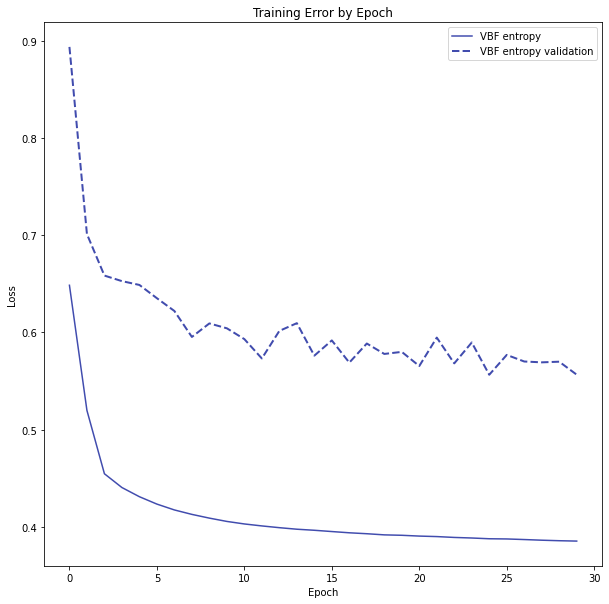

In [22]:
show_losses( [("VBF entropy", hist)])

In [23]:
y_pred2 = model.predict(x_test)
y_pred = y_pred2.ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred, sample_weight = test_weight.ravel())

In [24]:
from sklearn.metrics import roc_auc_score
auc_keras = roc_auc_score(y_test, y_pred, sample_weight = test_weight.ravel())

ValueError: x is neither increasing nor decreasing : [0.         0.         0.         ... 0.99996344 0.99997757 1.        ].

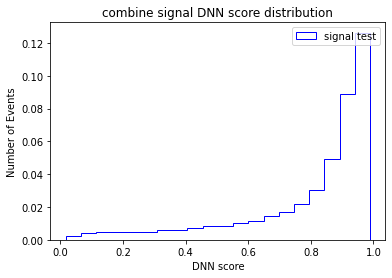

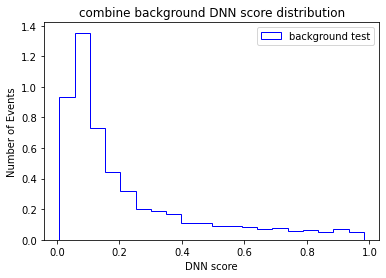

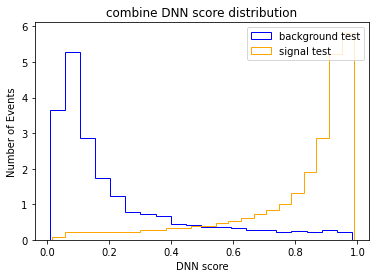

In [25]:
# Plot DNN score distribution

bgd = y_pred[y_test == 0]
sgl = y_pred[y_test == 1]
sgl_weight = test_weight[y_test == 1].flatten()
bgd_weight = test_weight[y_test == 0].flatten()

plt.hist(sgl, color='blue', weights= sgl_weight, histtype='step', bins = 20, label= 'signal test')
plt.xlabel('DNN score')
plt.ylabel('Number of Events')
#plt.vlines(0.55, ymin=0, ymax = 0.10, color = 'orange')
plt.legend(loc = 'best')
plt.title('combine signal DNN score distribution')
plt.savefig(fname = f'DNN_Score_Plts/full/combine_mass_sig_score_1.png', format='png')
plt.show()

plt.hist(bgd, color='blue', weights= bgd_weight, histtype='step', bins = 20, label= 'background test')
plt.xlabel('DNN score')
plt.ylabel('Number of Events')
#plt.vlines(0.5, ymin=0, ymax = 10, color = 'orange')
plt.legend(loc = 'best')
plt.title('combine background DNN score distribution')
plt.savefig(fname = f'DNN_Score_Plts/full/combine_mass_bkg_score_1.png', format='png')
plt.show()

plt.hist(bgd, color='blue', weights= bgd_weight, histtype='step', bins = 20, label= 'background test', density = True)
plt.hist(sgl, color='orange', weights= sgl_weight, histtype='step', bins = 24, label= 'signal test', density = True)
plt.xlabel('DNN score')
plt.ylabel('Number of Events')
plt.legend(loc = 'best')
plt.title('combine DNN score distribution')
plt.savefig(fname = f'DNN_Score_Plts/full/combine_mass_score_1.png', format='png')
plt.show()

In [26]:
bgd_x_all = x_all_test[y_test == 0]
bgd_y = y_pred[y_test == 0]
bgd_test = y_test[y_test == 0]

sig_x_all = x_all_test[y_test == 1]
sig_y = y_pred[y_test == 1]
sig_test = y_test[y_test == 1]

result_sig_df = pd.DataFrame(sig_x_all, columns = list(sig_df.columns))
result_sig_df[b'genweight_scale'] = result_sig_df.loc[:, b'genweight'].values * scale_sig
result_sig_df[b'DNN_score'] = sig_y
result_bgd_df = pd.DataFrame(bgd_x_all, columns = list(bkg_df.columns))
result_bgd_df[b'genweight_scale'] = result_bgd_df.loc[:, b'genweight'].values * scale_bgd
result_bgd_df[b'DNN_score'] = bgd_y

In [27]:
# Make copy of dataframe

result_sig_df_alt = pd.DataFrame()
result_bgd_df_alt = pd.DataFrame()
for column in list(result_sig_df.columns):
    result_sig_df_alt[column] = result_sig_df.loc[:, column].values
    result_bgd_df_alt[column] = result_bgd_df.loc[:, column].values

In [28]:
from ROOT import RDF
from ROOT import Internal

result_sig_dict = {key.decode("utf-8"): result_sig_df_alt[key].values for key in list(result_sig_df_alt.columns)}
result_bgd_dict = {key.decode("utf-8"): result_bgd_df_alt[key].values for key in list(result_bgd_df_alt.columns)}
sig_rdf = rt.RDF.MakeNumpyDataFrame(result_sig_dict)
bgd_rdf = rt.RDF.MakeNumpyDataFrame(result_bgd_dict)
sig_rdf.Snapshot('tree', f'DNN_Trees/combine_sequential_DNN/sig_combine_seqDNN.root')
bgd_rdf.Snapshot('tree', f'DNN_Trees/combine_sequential_DNN/bgd_combine_seqDNN.root')

<cppyy.gbl.ROOT.RDF.RResultPtr<ROOT::RDF::RInterface<ROOT::Detail::RDF::RLoopManager,void> > object at 0x588f0f80>

In [29]:
mc_labels = ['VBFToHH',
            'VHToGG', 'ttHToGG', 'VBFHToGG', 'GluGluHtoGG']
result_bgd_dfs_lst = []

for i in range(len(mc_labels)):
    samp_df = result_bgd_df_alt[result_bgd_df_alt[b'label_num'] == i]
    result_bgd_dfs_lst.append(samp_df)
    samp_dict = {key.decode("utf-8"): samp_df[key].values for key in list(samp_df.columns)}
    samp_rdf = rt.RDF.MakeNumpyDataFrame(samp_dict)
    samp_rdf.Snapshot('tree',f'DNN_Trees/combine_sequential_DNN/{mc_labels[i]}_combine_seqDNN.root' )

In [30]:
# Bkg reduction
def significance_file(k):
    file.write(f'cutoff: {k}\n')
    bgd = y_pred[y_test == 0]
    file.write(f'# background: {len(bgd)}\n')
    bgd_bin = []
    for event in bgd:
        if event >= k:
            bgd_bin.append(1)
        else:
            bgd_bin.append(0)
    file.write(f'# false signal: {sum(bgd_bin)}\n')

    sgl = y_pred[y_test == 1]
    file.write(f'# signal: {len(sgl)}\n')
    sgl_bin = []
    for event in sgl:
        if event >= k:
            sgl_bin.append(1)
        else:
            sgl_bin.append(0)
    file.write(f'# true signal: {sum(sgl_bin)}\n')
    bgd_bin_np = np.array(bgd_bin)
    sgl_bin_np = np.array(sgl_bin)
    sgl_weight = test_weight[y_test == 1].flatten() * scale_sig
    bgd_weight = test_weight[y_test == 0].flatten() * scale_bgd
    file.write(f'original background: {np.sum(bkg_weight_np_sfl)}\n')
    file.write(f'original test background: {np.sum(bgd_weight)}\n')
    file.write(f'original signal: {np.sum(sig_weight_np_sfl)}\n')
    file.write(f'original test signal: {np.sum(sgl_weight)}\n')

    re_bkg = np.sum(bgd_bin_np * bgd_weight)
    file.write(f'remaining background: {re_bkg}\n')
    re_sig = np.sum(sgl_bin_np * sgl_weight)
    file.write(f'remaining signal: {re_sig}\n')
    file.write(f'original S/sqrt(S+B): {np.sum(sig_weight_np_sfl) / np.sqrt(np.sum(sig_weight_np_sfl) + np.sum(bkg_weight_np_sfl))}\n')
    file.write(f'original test S/sqrt(S+B): {np.sum(sgl_weight) / np.sqrt(np.sum(sgl_weight) + np.sum(bgd_weight))}\n')
    file.write(f'S/sqrt(S+B): {re_sig / np.sqrt(re_sig + re_bkg)}\n')
    file.write('\n')
    return re_sig / np.sqrt(re_sig + re_bkg)

def significance_print(k):
    print(f'cutoff: {k}')
    bgd = y_pred[y_test == 0]
    print(f'# background: {len(bgd)}\n')
    bgd_bin = []
    for event in bgd:
        if event >= k:
            bgd_bin.append(1)
        else:
            bgd_bin.append(0)
    print(f'# false signal: {sum(bgd_bin)}\n')

    bgd = y_pred[y_test == 0]
    print(f'# signal: {len(sgl)}')
    sgl_bin = []
    for event in sgl:
        if event >= k:
            sgl_bin.append(1)
        else:
            sgl_bin.append(0)
    print(f'# true signal: {sum(sgl_bin)}\n')
    bgd_bin_np = np.array(bgd_bin)
    sgl_bin_np = np.array(sgl_bin)
    sgl_weight = test_weight[y_test == 1].flatten() * scale_sig
    bgd_weight = test_weight[y_test == 0].flatten() * scale_bgd
    print(f'original background: {np.sum(bkg_weight_np_sfl)}')
    print(f'original test background: {np.sum(bgd_weight)}')
    print(f'original signal: {np.sum(sig_weight_np_sfl)}')
    print(f'original test signal: {np.sum(sgl_weight)}')

    re_bkg = np.sum(bgd_bin_np * bgd_weight)
    print(f'remaining background: {re_bkg}\n')
    re_sig = np.sum(sgl_bin_np * sgl_weight)
    print(f'remaining signal: {re_sig}\n')
    print(f'original S/sqrt(S+B): {np.sum(sig_weight_np_sfl) / np.sqrt(np.sum(sig_weight_np_sfl) + np.sum(bkg_weight_np_sfl))}\n')
    print(f'original test S/sqrt(S+B): {np.sum(sgl_weight) / np.sqrt(np.sum(sgl_weight) + np.sum(bgd_weight))}\n')
    print(f'S/sqrt(S+B): {re_sig / np.sqrt(re_sig + re_bkg)}\n')
    print('\n')
    return re_sig / np.sqrt(re_sig + re_bkg)

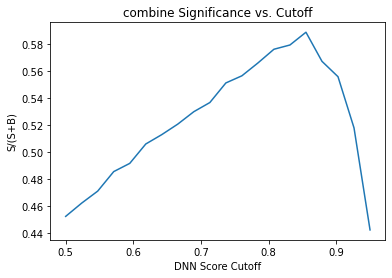

In [31]:
test_sc = np.linspace(0.5, 0.95, 20)
sc_vals = []
file = open('DNN_Score_Nums/full/combine_mass_DNN_score_1.txt', "w")
for value in test_sc:
    sc_vals.append(significance_file(value))

file.close()
    
plt.plot(test_sc, sc_vals, label = 'combine')
plt.xlabel('DNN Score Cutoff')
plt.ylabel('S/(S+B)')
plt.title('combine Significance vs. Cutoff')
plt.savefig(fname = f'DNN_Score_Plts/full/combine_mass_significance_1.png', format='png')
plt.show()

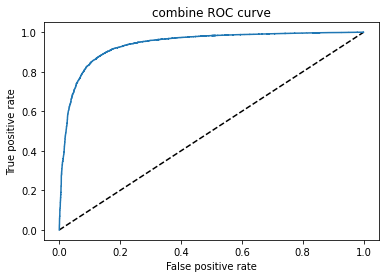

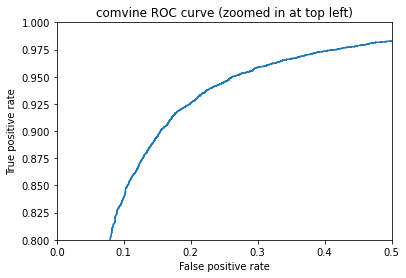

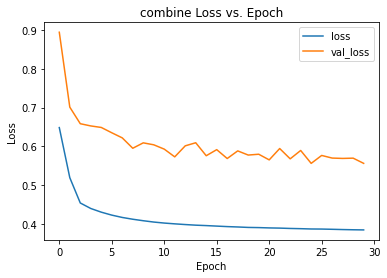

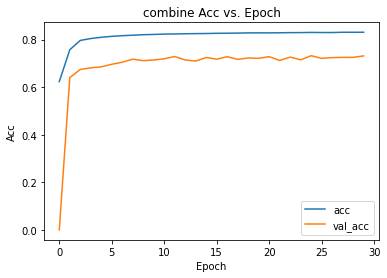

In [32]:
# Plots

# ROC curve
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras)
#plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('combine ROC curve')
#plt.legend(loc='best')
plt.savefig(fname = f'ROC_Plts/full/combine_mass_ROC_curve.png', format='png')
plt.show()

# Zoom in view of the upper left corner ROC curve
plt.figure(2)
plt.xlim(0, 0.5)
plt.ylim(0.8, 1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras)
#plt.plot(fpr_keras, tpr_keras, label= 'Keras (area = {:.3f})'.format(auc_keras))
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')
plt.title('comvine ROC curve (zoomed in at top left)')
#plt.legend(loc='best')
plt.savefig(fname = f'ROC_Plts/full/combine_mass_ROC_curve_zoom_1')
plt.show()


# plot loss vs epoch
plt.figure(3)
plt.plot(hist.history['loss'], label='loss')
plt.plot(hist.history['val_loss'], label='val_loss')
plt.legend(loc="best")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('combine Loss vs. Epoch')
plt.savefig(fname = f'Epoch_Plts/full/combine_mass_loss_epoch_1.png', format='png')
plt.show()

# plot accuracy vs epoch
plt.figure(4)
plt.plot(hist.history['accuracy'], label='acc')
plt.plot(hist.history['val_accuracy'], label='val_acc')
plt.legend(loc="best")
plt.xlabel('Epoch')
plt.ylabel('Acc')
plt.title('combine Acc vs. Epoch')
plt.savefig(fname = f'Epoch_Plts/full/combine_mass_acc_epoch_1.png', format='png')
plt.show()

In [33]:
file = open('Efficiency/full/combine_mass_DNN_efficiency_1.txt', "w")
file.write('1% acceptance\n')
for x in tpr_keras[fpr_keras>=0.009997]:
    if x in tpr_keras[fpr_keras<=0.01]:
        file.write(f'{x}\n')

file.write('\n')

file.write('0.1% acceptance\n')
for y in tpr_keras[fpr_keras>=0.0009997]:
    if y in tpr_keras[fpr_keras<=0.001]:
        file.write(f'{y}\n')
file.close()

In [34]:
def check_mass_gg(label, test_all, var_index, weight_index, dnn_index, label_index):
    samples = ['Background', 'Signal']
    fontsize=25
    TPR_thresholds = [0.8,0.7,0.6, 0.5, 0.4, 0.3,0.2]
    bins = np.linspace(110, 140, 30)
    plt.figure(figsize=(9,6))
    plt.hist(test_all[:,var_index][test_all[:,label_index]==label], bins=bins, weights=test_all[:,weight_index][test_all[:,label_index]==label], density=True, label='No cut')
    for TPR_threshold in TPR_thresholds:
        #print(TPR_threshold)
    
        tmp = test_all[np.where((test_all[:,label_index]==label)*(test_all[:,dnn_index]>TPR_threshold))]
        plt.hist(tmp[:,var_index],
             bins=bins, histtype='step', 
             weights=tmp[:,weight_index], 
             label= "{:.0f}% bkg eff".format(100*TPR_threshold),
             density=True)
    
    plt.legend(loc='best')
    plt.ylabel(samples[label] + ' events (normalized to unit area)',fontsize=16)
    plt.xlabel(r'$m_{\gamma\gamma}$',fontsize=fontsize)
    plt.title('combine '+samples[label])
    plt.savefig(fname = f'Mass_Sculpt_Plts/full/combine_mass_gg_mass_sculpt_{samples[label]}_1')
    
def check_mass_jj(label, test_all, var_index, weight_index, dnn_index, label_index):
    samples = ['Background', 'Signal']
    fontsize=25
    TPR_thresholds = [0.8,0.7,0.6, 0.5, 0.4, 0.3,0.2]
    bins = np.linspace(110, 140, 30)
    plt.figure(figsize=(9,6))
    plt.hist(test_all[:,var_index][test_all[:,label_index]==label], bins=bins, weights=test_all[:,weight_index][test_all[:,label_index]==label], density=True, label='No cut')
    for TPR_threshold in TPR_thresholds:
        #print(TPR_threshold)
    
        tmp = test_all[np.where((test_all[:,label_index]==label)*(test_all[:,dnn_index]>TPR_threshold))]
        plt.hist(tmp[:,var_index],
             bins=bins, histtype='step', 
             weights=tmp[:,weight_index], 
             label= "{:.0f}% bkg eff".format(100*TPR_threshold),
             density=True)
    
    plt.legend(loc='best')
    plt.ylabel(samples[label] + ' events (normalized to unit area)',fontsize=16)
    plt.xlabel(r'$m_{jj}$',fontsize=fontsize)
    plt.title('combine '+samples[label])
    plt.savefig(fname = f'Mass_Sculpt_Plts/full/combine_mass_jj_mass_sculpt_{samples[label]}_1')

In [35]:
def check_mass_gg_full(label, test_all, var_index, weight_index, dnn_index, label_index):
    samples = ['Background', 'Signal']
    fontsize=25
    TPR_thresholds = [0.8,0.7,0.6, 0.5, 0.4, 0.3,0.2]
    bins = np.linspace(100, 180, 20)
    plt.figure(figsize=(9,6))
    plt.hist(test_all[:,var_index][test_all[:,label_index]==label], bins=bins, weights=test_all[:,weight_index][test_all[:,label_index]==label], density=True, label='No cut')
    for TPR_threshold in TPR_thresholds:
        #print(TPR_threshold)
    
        tmp = test_all[np.where((test_all[:,label_index]==label)*(test_all[:,dnn_index]>TPR_threshold))]
        plt.hist(tmp[:,var_index],
             bins=bins, histtype='step', 
             weights=tmp[:,weight_index], 
             label= "{:.0f}% bkg eff".format(100*TPR_threshold),
             density=True)
    
    plt.legend(loc='best')
    plt.ylabel(samples[label] + ' events (normalized to unit area)',fontsize=16)
    plt.xlabel(r'$m_{\gamma\gamma}$',fontsize=fontsize)
    plt.title('combine '+samples[label])
    #plt.savefig(fname = f'Mass_Sculpt_Plts/full/combine_mass_gg_mass_sculpt_{samples[label]}_1')
    
def check_mass_jj_full(label, test_all, var_index, weight_index, dnn_index, label_index):
    samples = ['Background', 'Signal']
    fontsize=25
    TPR_thresholds = [0.8,0.7,0.6, 0.5, 0.4, 0.3,0.2]
    bins = np.linspace(70, 190, 20)
    plt.figure(figsize=(9,6))
    plt.hist(test_all[:,var_index][test_all[:,label_index]==label], bins=bins, weights=test_all[:,weight_index][test_all[:,label_index]==label], density=True, label='No cut')
    for TPR_threshold in TPR_thresholds:
        #print(TPR_threshold)
    
        tmp = test_all[np.where((test_all[:,label_index]==label)*(test_all[:,dnn_index]>TPR_threshold))]
        plt.hist(tmp[:,var_index],
             bins=bins, histtype='step', 
             weights=tmp[:,weight_index], 
             label= "{:.0f}% bkg eff".format(100*TPR_threshold),
             density=True)
    
    plt.legend(loc='best')
    plt.ylabel(samples[label] + ' events (normalized to unit area)',fontsize=16)
    plt.xlabel(r'$m_{jj}$',fontsize=fontsize)
    plt.title('combine '+samples[label])
    #plt.savefig(fname = f'Mass_Sculpt_Plts/full/combine_mass_jj_mass_sculpt_{samples[label]}_1')

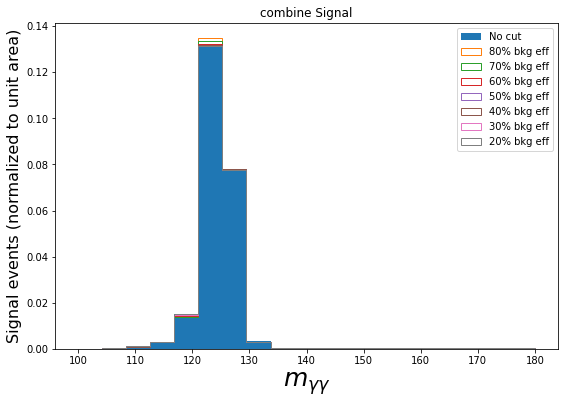

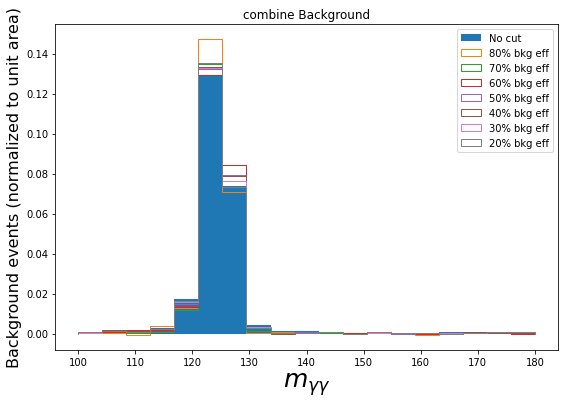

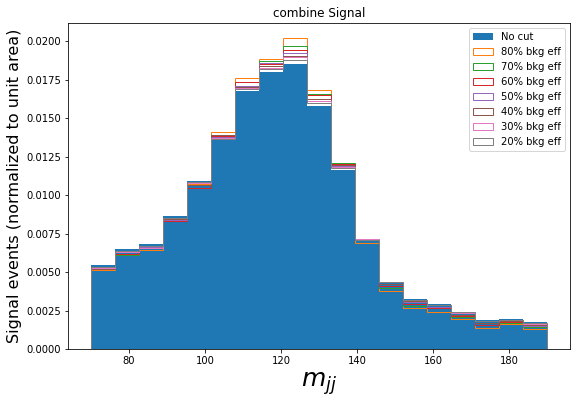

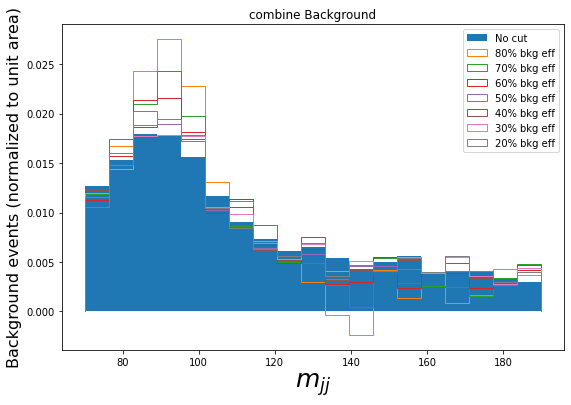

In [36]:
label_test = np.array([y_test]).T
test_all = np.concatenate((x_all_test,y_pred2, label_test), 1)
#signal
check_mass_gg_full(1, test_all, 29, 27, 32, 33)
#bkg
check_mass_gg_full(0, test_all, 29, 27, 32, 33)

#signal
check_mass_jj_full(1, test_all, 28, 27, 32, 33)
#bkg
check_mass_jj_full(0, test_all, 28, 27, 32, 33)

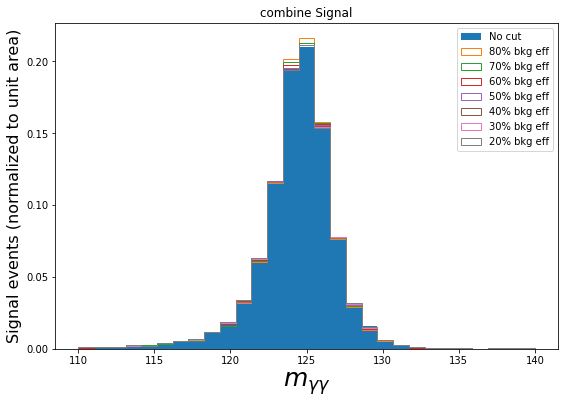

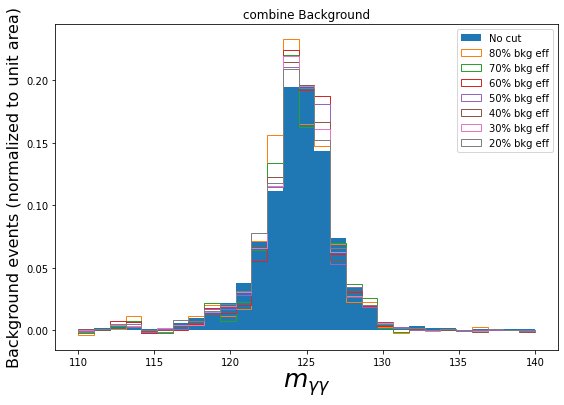

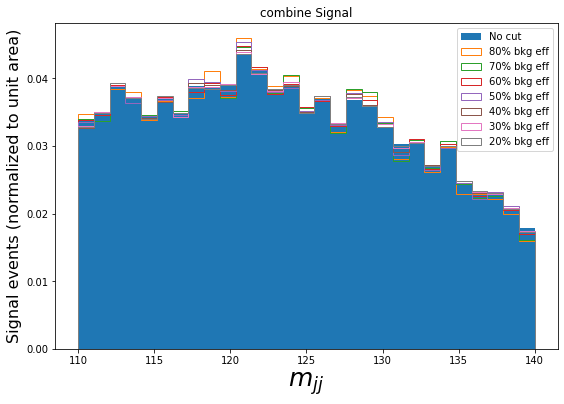

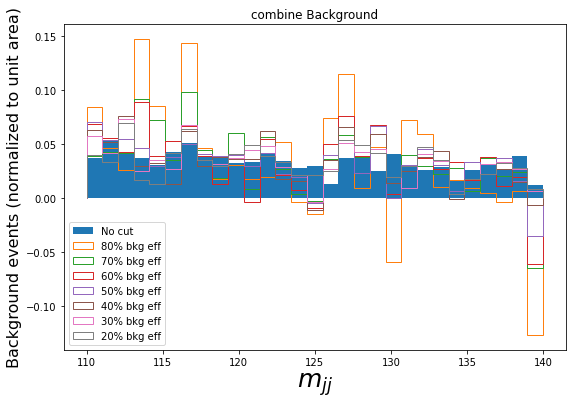

In [37]:
label_test = np.array([y_test]).T
test_all = np.concatenate((x_all_test,y_pred2, label_test), 1)
#signal
check_mass_gg(1, test_all, 29, 27, 32, 33)
#bkg
check_mass_gg(0, test_all, 29, 27, 32, 33)

#signal
check_mass_jj(1, test_all, 28, 27, 32, 33)
#bkg
check_mass_jj(0, test_all, 28, 27, 32, 33)

In [38]:
# per background mass sculpting -- code still in progress

def check_mass_gg_samp(label, test_all, var_index, weight_index, dnn_index, label_index, samp_index, samp):
    fontsize=25
    TPR_thresholds = [0.8,0.7,0.6, 0.5, 0.4, 0.3,0.2]
    bins = np.linspace(110, 140, 20)
    samp_test_all = test_all[test_all[:, samp_index]==samp]
    plt.figure(figsize=(9,6))
    plt.hist(samp_test_all[:,var_index][samp_test_alll[:,label_index]==label], bins=bins, weights=samp_test_all[:,weight_index][samp_test_all[:,label_index]==label], density=True, label='No cut')
    for TPR_threshold in TPR_thresholds:
        #print(TPR_threshold)
    
        tmp = samp_test_all[np.where((samp_test_all[:,label_index]==label)*(samp_test_all[:,dnn_index]>TPR_threshold))]
        plt.hist(tmp[:,var_index],
             bins=bins, histtype='step', 
             weights=tmp[:,weight_index], 
             label= "{:.0f}% bkg eff".format(100*TPR_threshold),
             density=True)
    
    plt.legend(loc='best')
    plt.ylabel(samples[label] + ' events (normalized to unit area)',fontsize=16)
    plt.xlabel(r'$m_{\gamma\gamma}$',fontsize=fontsize)
    plt.title('combine '+samples[label])
    plt.savefig(fname = f'Mass_Sculpt_Plts/full/combine_mass_gg_mass_sculpt_{samples[label]}_1')
    
def check_mass_jj_samp(label, test_all, var_index, weight_index, dnn_index, label_index, samp_index):
    samples = ['Background', 'Signal']
    fontsize=25
    TPR_thresholds = [0.8,0.7,0.6, 0.5, 0.4, 0.3,0.2]
    bins = np.linspace(110, 140, 20)
    plt.figure(figsize=(9,6))
    plt.hist(test_all[:,var_index][test_all[:,label_index]==label], bins=bins, weights=test_all[:,weight_index][test_all[:,label_index]==label], density=True, label='No cut')
    for TPR_threshold in TPR_thresholds:
        #print(TPR_threshold)
    
        tmp = test_all[np.where((test_all[:,label_index]==label)*(test_all[:,dnn_index]>TPR_threshold))]
        plt.hist(tmp[:,var_index],
             bins=bins, histtype='step', 
             weights=tmp[:,weight_index], 
             label= "{:.0f}% bkg eff".format(100*TPR_threshold),
             density=True)
    
    plt.legend(loc='best')
    plt.ylabel(samples[label] + ' events (normalized to unit area)',fontsize=16)
    plt.xlabel(r'$m_{jj}$',fontsize=fontsize)
    plt.title('combine '+samples[label])
    plt.savefig(fname = f'Mass_Sculpt_Plts/full/combine_mass_jj_mass_sculpt_{samples[label]}_1')

In [39]:
# addressing mass sculpting?

# following: https://github.com/eric-moreno/IN/blob/b2a9cd7bfc3085900876ffd221e9e3f2ac36ba43/make_good_plots.py#L270-L292

from sklearn.ensemble import GradientBoostingRegressor


def quantile_regression_DDT_FPR(dfs, dfs_train, FPR_cut): 
        
        print('Fitting Quantile Reg. of FPR = ' + str(FPR_cut))
        data_train = dfs_train.loc[b'diphoton_mass'].values
        data = dfs.loc[b'diphoton_mass'].values

        if FPR_cut > 10: 
            aux_scale = 0.1*float(FPR_cut)/3000.
        
        else: 
            aux_scale = 0.1*float(FPR_cut)/100.
            
        model = GradientBoostingRegressor(loss='quantile', alpha=1-float(FPR_cut)/100, 
                                          n_estimators=500, 
                                          min_samples_leaf=50, 
                                          min_samples_split=2500, 
                                          max_depth = 5, 
                                          validation_fraction=0.2, 
                                          n_iter_no_change=10, tol=1e-3, 
                                          verbose=1, random_state=42)
        model.fit(data_train, dfs.loc[dfs['truth'+'QCD'] == 1]['predict'+'Hbb'].values/aux_scale)
        cuts = aux_scale*model.predict(data)
        return cuts
    
def mass_DNN_score(df, FPR_cut, mass_min, mass_max):
    df_range = df[df[b'diphoton_mass'] <= mass_max][df[b'diphoton_mass'] >= mass_min]
    #ms_vars = [b'diphoton_mass', b'DNN_score', b'genweight']
    #df_values = df_range[ms_vars]
    df_values = df_range.sort_values(by = [b'DNN_score'])
    #print(df_values.columns)
    #print(df_values.head())
    #df_values.get(b'genweight')
    weight_array = df_values.loc[:, b'genweight'].values
    DNN_score_array = df_values.loc[:, b'DNN_score'].values
    total_weight = np.sum(weight_array)
    tn_percent = 1 - FPR_cut
    tn_weight = total_weight * tn_percent
    weight_sum = 0
    for i in range(weight_array.shape[0]):
        weight_sum += weight_array[i]
        if weight_sum >= tn_weight:
            return DNN_score_array[i]

In [40]:
bins = np.linspace(100, 180, 80)
FPR = 8
DNN_cuts = []
for i in range(bins.shape[0] - 1):
    DNN_cuts.append(mass_DNN_score(result_bgd_df, FPR / 100, bins[i], bins[i+1]))
    
print(DNN_cuts)

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:33: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:33: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:33: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:33: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:33: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:33: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:33: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/li

[0.15172487, 0.2828091, 0.037559953, 0.81324285, 0.66569924, 0.5364392, 0.40166453, 0.09635952, 0.07600663, 0.010844786, 0.9299471, 0.26081902, 0.7822326, 0.93493366, 0.14708877, 0.096784756, 0.4294371, 0.57314235, 0.7239315, 0.5755933, 0.53162634, 0.5968871, 0.7377335, 0.6762945, 0.64509803, 0.714685, 0.639169, 0.6076289, 0.5954172, 0.5741262, 0.09994092, 0.45344067, 0.2915797, 0.09766399, 0.15171863, 0.18674016, 0.20008312, 0.41333443, 0.09279653, 0.08483573, 0.75968623, 0.19755356, 0.04697471, 0.6965464, 0.061575178, 0.8489663, 0.01985143, 0.058633424, 0.14987898, 0.09715052, 0.2702344, 0.69083905, 0.43388942, 0.25883016, 0.090054005, 0.08235416, 0.0119210975, 0.04511762, 0.39982253, 0.033875093, 0.56928784, 0.45737854, 0.3050247, 0.065285645, 0.11562188, 0.44759017, 0.072482795, 0.5604559, 0.23783517, 0.21697538, 0.08239588, 0.92049086, 0.12098124, 0.26826453, 0.23614597, 0.47463512, 0.50469446, 0.23146658, 0.17460765]


In [46]:
bins = np.linspace(100, 180, 80)
bkd_cut = []
sig_cut = []
result_bgd_df_sort = result_bgd_df.sort_values(by = [b'diphoton_mass'])
result_sig_df_sort = result_sig_df.sort_values(by = [b'diphoton_mass'])

for i in range(bins.shape[0] - 1):
    mass_min = bins[i]
    mass_max = bins[i+1]
    df_bkg = result_bgd_df_sort[result_bgd_df_sort[b'diphoton_mass'] <= mass_max][result_bgd_df_sort[b'diphoton_mass'] >= mass_min]
    df_sig = result_sig_df_sort[result_sig_df_sort[b'diphoton_mass'] <= mass_max][result_sig_df_sort[b'diphoton_mass'] >= mass_min]
    bkg_DNN = df_bkg.loc[:, b'DNN_score'].values
    sig_DNN = df_sig.loc[:, b'DNN_score'].values
    for j in range(bkg_DNN.shape[0]):
        if bkg_DNN[j] >= DNN_cuts[i]:
            bkd_cut.append(1)
        else:
            bkd_cut.append(0)
    for k in range(sig_DNN.shape[0]):
        if sig_DNN[k] >= DNN_cuts[i]:
            sig_cut.append(1)
        else:
            sig_cut.append(0)
result_bgd_df_sort[b'mass_sculpt_cut'] = bkd_cut
result_sig_df_sort[b'mass_sculpt_cut'] = sig_cut

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/py

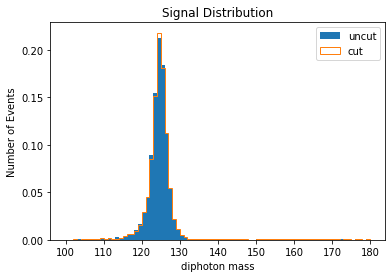

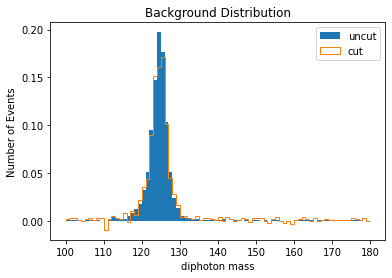

In [50]:
final_bgd_df = result_bgd_df_sort[result_bgd_df_sort[b'mass_sculpt_cut'] == 1]
final_sig_df = result_sig_df_sort[result_sig_df_sort[b'mass_sculpt_cut'] == 1]
ori_sig_mass = result_sig_df_sort.loc[:, b'diphoton_mass'].values
ori_sig_weight = result_sig_df_sort.loc[:, b'genweight'].values
cut_sig_mass = final_sig_df.loc[:, b'diphoton_mass'].values
cut_sig_weight = final_sig_df.loc[:, b'genweight'].values
ori_bgd_mass = result_bgd_df_sort.loc[:, b'diphoton_mass'].values
ori_bgd_weight = result_bgd_df_sort.loc[:, b'genweight'].values
cut_bgd_mass = final_bgd_df.loc[:, b'diphoton_mass'].values
cut_bgd_weight = final_bgd_df.loc[:, b'genweight'].values

plt.figure()
plt.hist(ori_sig_mass, bins = 80, range=(100, 180), weights = ori_sig_weight, label = 'uncut', density=True)
plt.hist(cut_sig_mass, bins = 80, range=(100, 180), weights = cut_sig_weight, histtype='step', label = 'cut', density=True )
plt.legend(loc = 'best')
plt.xlabel('diphoton mass')
plt.ylabel('Number of Events')
plt.title('Signal Distribution')
plt.savefig(fname = f'Mass_Sculpt_Plts/full/combine_mgg_sig_cut_{FPR}')
plt.show()

plt.figure()
plt.hist(ori_bgd_mass, bins = 80, range=(100, 180), weights = ori_bgd_weight, label = 'uncut', density = True)
plt.hist(cut_bgd_mass, bins = 80, range=(100, 180), weights = cut_bgd_weight, histtype='step', label = 'cut', density = True )
plt.legend(loc = 'best')
plt.xlabel('diphoton mass')
plt.ylabel('Number of Events')
plt.title('Background Distribution')
plt.savefig(fname = f'Mass_Sculpt_Plts/full/combine_mgg_bgd_cut_{FPR}')
plt.show()

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:33: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:33: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:33: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:33: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:33: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:33: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:33: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/li

[0.2966475, 0.5923417, 0.6233549, 0.47675434, 0.59318084, 0.66594267, 0.6898942, 0.5710104, 0.15171863, 0.19581868, 0.6965464, 0.10137123, 0.35786813, 0.49269804, 0.32767168, 0.11562188, 0.5604559, 0.49532902, 0.47463512]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  app.launch_new_instance()
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  app.launch_new_instance()
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning: Boolean Series key will be reindexed t

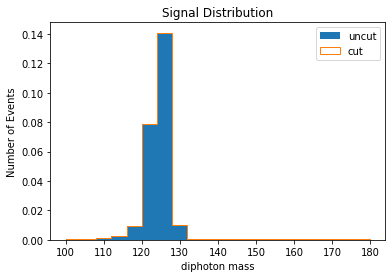

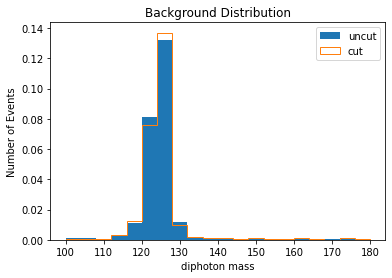

In [49]:
bins = np.linspace(100, 180, 20)
FPR = 8
DNN_cuts_small = []
for i in range(bins.shape[0] - 1):
    DNN_cuts_small.append(mass_DNN_score(result_bgd_df_sort, FPR / 100, bins[i], bins[i+1]))
    
print(DNN_cuts_small)

bkd_cut_small = []
sig_cut_small = []

for i in range(bins.shape[0] - 1):
    mass_min = bins[i]
    mass_max = bins[i+1]
    df_bkg = result_bgd_df_sort[result_bgd_df_sort[b'diphoton_mass'] <= mass_max][result_bgd_df_sort[b'diphoton_mass'] >= mass_min]
    df_sig = result_sig_df_sort[result_sig_df_sort[b'diphoton_mass'] <= mass_max][result_sig_df_sort[b'diphoton_mass'] >= mass_min]
    bkg_DNN = df_bkg.loc[:, b'DNN_score'].values
    sig_DNN = df_sig.loc[:, b'DNN_score'].values
    for j in range(bkg_DNN.shape[0]):
        if bkg_DNN[j] >= DNN_cuts[i]:
            bkd_cut_small.append(1)
        else:
            bkd_cut_small.append(0)
    for k in range(sig_DNN.shape[0]):
        if sig_DNN[k] >= DNN_cuts[i]:
            sig_cut_small.append(1)
        else:
            sig_cut_small.append(0)
result_bgd_df_sort[b'mass_sculpt_cut_small'] = bkd_cut_small
result_sig_df_sort[b'mass_sculpt_cut_small'] = sig_cut_small

final_bgd_df_small = result_bgd_df_sort[result_bgd_df[b'mass_sculpt_cut_small'] == 1]
final_sig_df_small = result_sig_df_sort[result_sig_df[b'mass_sculpt_cut_small'] == 1]
ori_sig_mass_small = result_sig_df_sort.loc[:, b'diphoton_mass'].values
ori_sig_weight_small = result_sig_df_sort.loc[:, b'genweight'].values
cut_sig_mass_small = final_sig_df_small.loc[:, b'diphoton_mass'].values
cut_sig_weight_small = final_sig_df_small.loc[:, b'genweight'].values
ori_bgd_mass_small = result_bgd_df_sort.loc[:, b'diphoton_mass'].values
ori_bgd_weight_small = result_bgd_df_sort.loc[:, b'genweight'].values
cut_bgd_mass_small = final_bgd_df_small.loc[:, b'diphoton_mass'].values
cut_bgd_weight_small = final_bgd_df_small.loc[:, b'genweight'].values

plt.figure()
plt.hist(ori_sig_mass_small, bins = 20, range=(100, 180), weights = ori_sig_weight_small, label = 'uncut', density=True)
plt.hist(cut_sig_mass_small, bins = 20, range=(100, 180), weights = cut_sig_weight_small, histtype='step', label = 'cut', density=True )
plt.legend(loc = 'best')
plt.xlabel('diphoton mass')
plt.ylabel('Number of Events')
plt.title('Signal Distribution')
plt.savefig(fname = f'Mass_Sculpt_Plts/full/combine_mgg_sig_cut_sm{FPR}')
plt.show()

plt.figure()
plt.hist(ori_bgd_mass_small, bins = 20, range=(100, 180), weights = ori_bgd_weight_small, label = 'uncut', density = True)
plt.hist(cut_bgd_mass_small, bins = 20, range=(100, 180), weights = cut_bgd_weight_small, histtype='step', label = 'cut', density = True )
plt.legend(loc = 'best')
plt.xlabel('diphoton mass')
plt.ylabel('Number of Events')
plt.title('Background Distribution')
plt.savefig(fname = f'Mass_Sculpt_Plts/full/combine_mgg_bgd_cut_sm{FPR}')
plt.show()

In [48]:
for hlf in training_vars:
    plt.figure()
    plt.hist(sig_df[hlf], bins=40, density=True, weights=sig_df[b'genweight'],
             histtype='step', label='signal')
    plt.hist(bkg_df[hlf], bins=40, density=True, weights=bkg_df[b'genweight'], 
             histtype='step', label= 'combined background')
    plt.xlabel(hlf)
    plt.legend(loc='best')
    plt.savefig(fname = f'BackgroundVsSignal_Plts/full/combine_{hlf}_1')
    plt.close()

# 